<a href="https://colab.research.google.com/github/CardiacModelling/summer-school-2025/blob/main/Hands_on_session_2_action_potential_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on session 2: action potential models

In this session,

...


* Downloading a CellML and loading into myokit
* Change the frequency
* Set up steady pacing experiment
* Have a look at APs, plot the now shorter/longer ones
* Calculate APDs
* Stick in a loop to draw a steady-state restitution curve.
* Apply simulated drug block or mutation by scaling a conductance and seeing how things change.
* Nice to show EAD or something happening, to link to arrhythmic whole-cell ideas (but let others do that).

## Run this first:

In [1]:
# Hide show the installation logs:
%%capture
# If installation fails, comment out the line above before running again

# Install Myokit and Sundials
!apt-get install libsundials-dev
!pip install myokit

# Disable debug messages annoyingly shown on colab
import logging
logging.disable(logging.INFO)

# Import myokit and matplotlib
import myokit
import matplotlib.pyplot as plt

## Importing a CellML model

AP models are rarely written "from scratch".
Instead, a typical study will start by either reimplementing a model based on published equations (very laborious!), or by reusing existing code.

To facilitate this, the cell electrophysiology community has developed a model exchange format, called [CellML](https://www.cellml.org/), and an online repository, called [PMR](https://models.physiomeproject.org/welcome).
Many cardiac AP models can be found in PMRs "Electrophysiology" section, or through the search function.

Here, we'll download and import the 2008 model of the rabbit ventricular AP by [Mahajan et al.](https://doi.org/10.1529/biophysj.106.98160).

### Obtaining the CellML file

To use this model in Google Colab, either:

1. Download it from [this PMR page](https://models.physiomeproject.org/exposure/a5586b72d07ce03fc40fc98ee846d7a5), then upload it to Colab using the "Files" tab on the left.
2. Download it directly, by uncommenting and running the `wget` command below:

In [2]:
# Uncomment to download directly from PMR
#!wget https://models.physiomeproject.org/workspace/mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008/download/e86beea89021fd242713459a5c4b5ea2ba33a445/mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml

In [3]:
# Uncomment to download from GitHub
!wget https://raw.githubusercontent.com/CardiacModelling/summer-school-2025/refs/heads/main/resources/mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml

--2025-10-03 15:26:40--  https://raw.githubusercontent.com/CardiacModelling/summer-school-2025/refs/heads/main/resources/mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147472 (144K) [text/plain]
Saving to: ‘mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml.2’

mahajan_shiferaw_sa 100%[===================>] 144.02K  --.-KB/s    in 0.1s    

2025-10-03 15:26:41 (1.28 MB/s) - ‘mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml.2’ saved [147472/147472]



### Importing the model in Myokit

To use the model in Myokit, we'll load the module [`myokit.formats`](https://myokit.readthedocs.io/en/stable/api_formats/index.html) and create a `CellMLImporter`

In [4]:
# Create a CellML importer
import myokit.formats
importer = myokit.formats.importer('cellml')

# Import the model
model = importer.model('mahajan_shiferaw_sato_baher_olcese_xie_yang_chen_restrepo_karma_garfinkel_qu_weiss_2008.cellml')

print(f'Imported model {model.name()}')

Imported model mahajan_2008


To see what we've imported, we can print the model's equations:

In [5]:
print(model.code())

[[model]]
author: Myokit CellML 1 API
documentation: """
    Model Status
    
    This model is known to run in OpenCell and COR to reproduce the output
    shown in the publication. The units have been checked and they are
    consistent.
    
    Model Structure
    
    ABSTRACT: Mathematical modeling of the cardiac action potential has proven
    to be a powerful tool for illuminating various aspects of cardiac function,
    including cardiac arrhythmias. However, no currently available detailed
    action potential model accurately reproduces the dynamics of the cardiac
    action potential and intracellular calcium (Ca(i)) cycling at rapid heart
    rates relevant to ventricular tachycardia and fibrillation. The aim of this
    study was to develop such a model. Using an existing rabbit ventricular
    action potential model, we modified the L-type calcium (Ca) current
    (I(Ca,L)) and Ca(i) cycling formulations based on new experimental patch-
    clamp data obtained in isolat

Near the very bottom, we spot a component named `cell` that contains a state variable `cell.V` in units of `mV`.

This has a defining equation of the form
\begin{align}
\frac{dV}{dt} = - \frac{1}{C} \sum{I}
\end{align}
(note that the division by C isn't written explicitly here, but introduced by writing all the currents in units of pA/pF).

Let's try running a simulation and plotting this variable.
Unlike before, we won't be using a `protocol` here (but see below!)

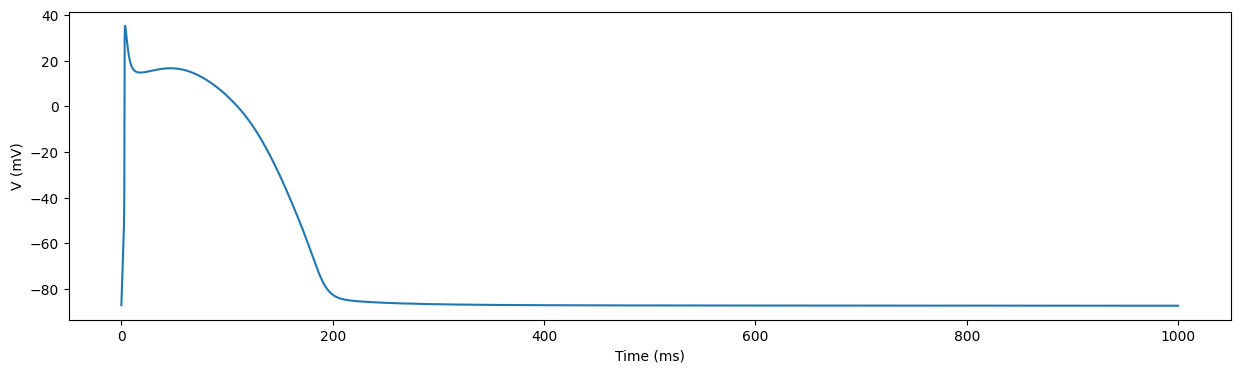

In [25]:
sim = myokit.Simulation(model)
log = sim.run(1000)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
plt.show()

That looks like an action potential!

But as we didn't provide a pacing protocol, where is the stimulus current coming from?
As in most CellML models, this is hardcoded in the model.
In this case, in the same component "`cell`":

In [26]:
print(model.get('cell').code())

[cell]
Itotal = -(INa.xina + IK1.xik1 + IKr.xikr + IKs.xiks + Ito.xito + INaCa.xiNaCa + ICaL.xica + INaK.xiNaK + i_Stim)
    in [A/F]
dot(V) = Itotal
    in [mV]
i_Stim = piecewise(Environment.time - past >= stim_offset and Environment.time - past <= stim_offset + stim_duration, stim_amplitude, 0 [A/F])
    in [A/F]
past = floor(Environment.time / stim_period) * stim_period
    in [ms]
stim_amplitude = -15 [A/F]
    in [A/F]
stim_duration = 3 [ms]
    in [ms]
stim_offset = 0 [ms]
    in [ms]
stim_period = 400 [ms]
    in [ms]
wca = 8 [g*m^5/s^3/A/mol (1000)]
    in [g*m^5/s^3/A/mol (1000)]




The variable `i_Stim` is defined as a piecewise function, equal to either `0` or `stim_amplitude`, depending on the simulation time and the `stim_x` variables below.

In particular, the variable `stim_period` indicates periodic pacing with a stimulus duration of 3ms and a period of 400ms (fast for a human, but this is a rabbit model).
But in our 1000ms simulation, we only saw a single AP...

To see what's happened, we'll plot each point visited by the simulation, and draw vertical lines at 400ms and 800ms, where we expected the second and third stimuli to appear.

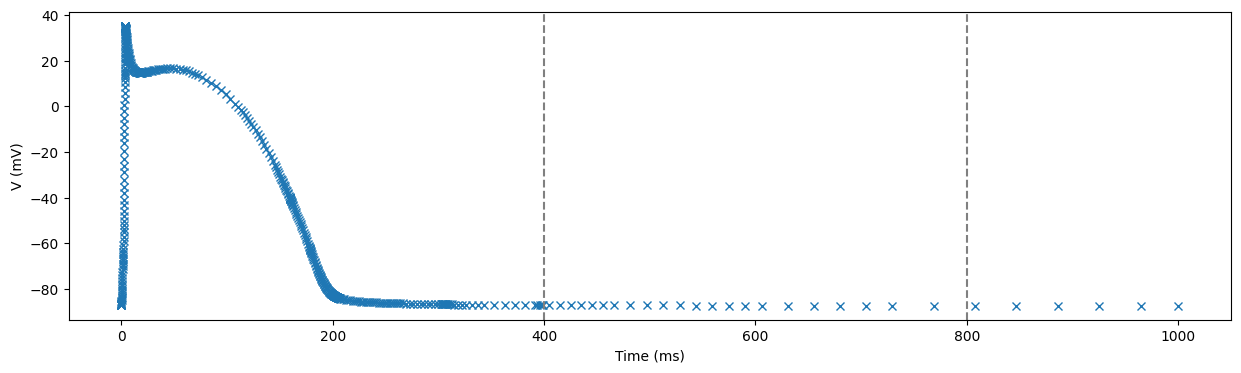

In [27]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'], 'x')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
ax.axvline(400, color='gray', ls='--')
ax.axvline(800, color='gray', ls='--')
plt.show()

As the simulation progresses, the variable step-size solver takes larger and larger steps.
Around 800ms, the steps are much larger than 3ms and so the simulation has missed the short stimulus entirely!

Near 400ms the situation is less clear, but we can zoom in to see the same thing happened:

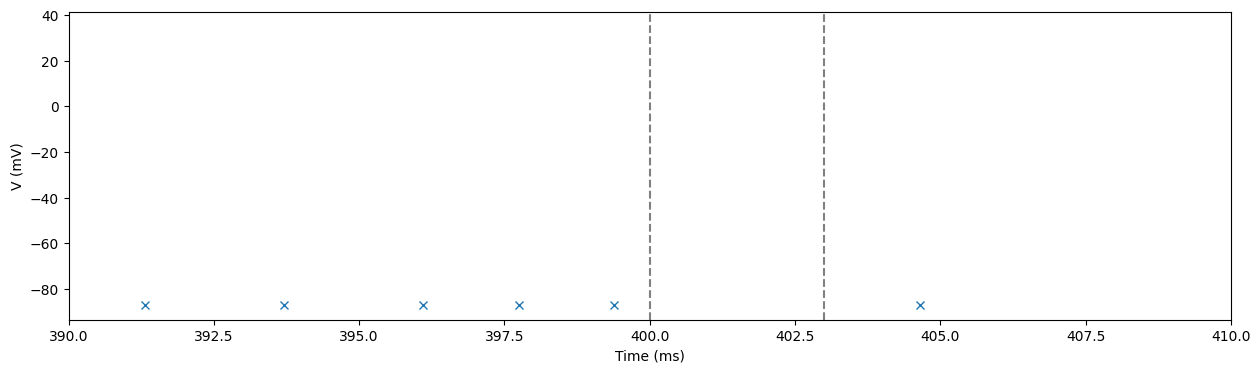

In [28]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'], 'x')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
ax.axvline(400, color='gray', ls='--')
ax.axvline(403, color='gray', ls='--')
ax.set_xlim(390, 410)
plt.show()

To fix this, we can _force_ the solver to take smaller steps.
By limiting step size to 3ms, the solver is guaranteed to land on a point within the stimulus.

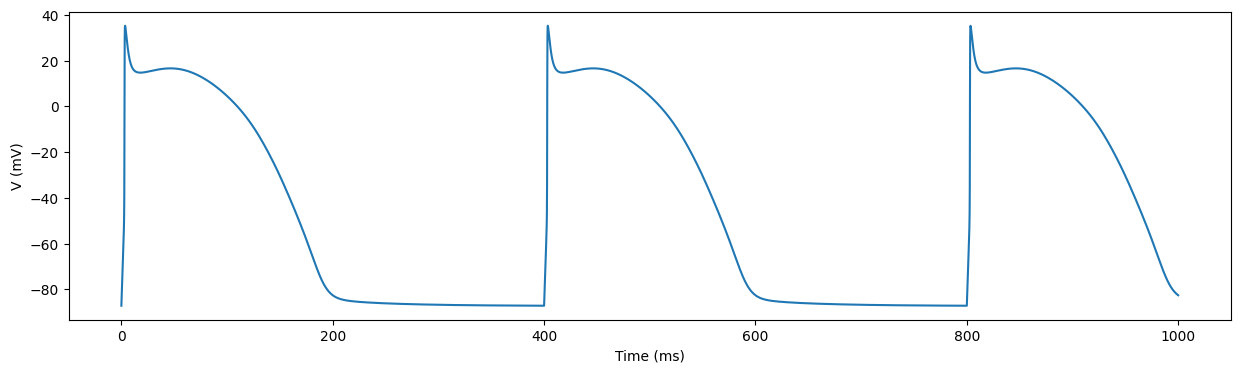

In [29]:
sim.reset()
sim.set_max_step_size(3)
log = sim.run(1000)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
plt.show()

And in fact, because it's a good solver, it will backtrack to hone in on the exact start of the the disctoninuous stimulus signal (notice the added points around 400ms).
Similarly, when the stimulus ends, at t=403ms, a large discontinuity will occur, which the simulation will track back to.

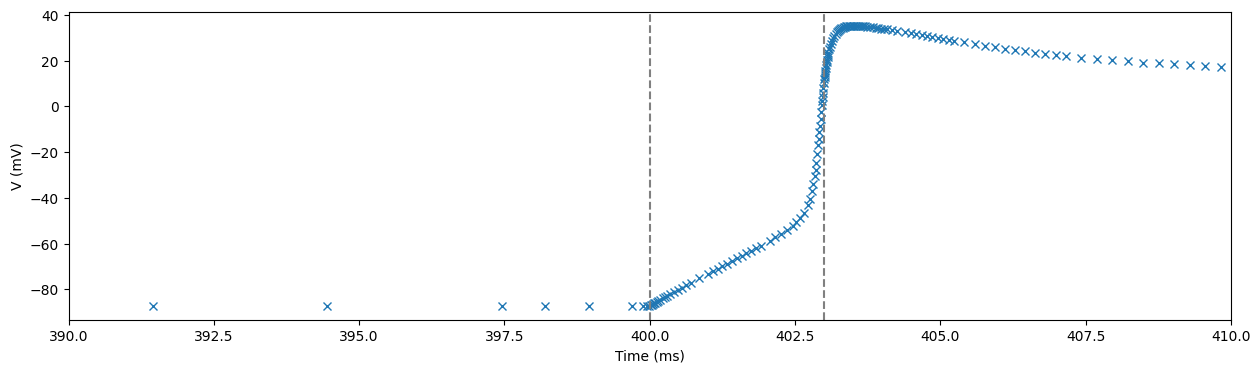

In [32]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'], 'x')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
ax.axvline(400, color='gray', ls='--')
ax.axvline(403, color='gray', ls='--')
ax.set_xlim(390, 410)
plt.show()

### Extracting the protocol from the model

Running with a maximum step size is not great for performance, so in general we want to modify the CellML file to replace the hard-coded stimulus with an entry point for a Myokit pacing protocol.

In many cases, this can be done automatically using the `myokit.lib.guess` module:

In [33]:
# Extract the protocol from the model, and update the model code
protocol = myokit.lib.guess.remove_embedded_protocol(model)

print(protocol)

[[protocol]]
# Level  Start    Length   Period   Multiplier
1.0      0.0      3.0      400.0    0


In [35]:
print(model.get('cell').code())

[cell]
Itotal = -(INa.xina + IK1.xik1 + IKr.xikr + IKs.xiks + Ito.xito + INaCa.xiNaCa + ICaL.xica + INaK.xiNaK + i_Stim)
    in [A/F]
dot(V) = Itotal
    in [mV]
i_Stim = pace * stim_amplitude
    in [A/F]
pace = 0 bind pace
    in [1]
past = floor(Environment.time / stim_period) * stim_period
    in [ms]
stim_amplitude = -15 [A/F]
    in [A/F]
stim_period = 400 [ms]
    in [ms]
wca = 8 [g*m^5/s^3/A/mol (1000)]
    in [g*m^5/s^3/A/mol (1000)]




Above, we can see the protocol has been correctly converted.

In the model, `i_Stim` is now defined as `pace * stim_amplitude`, where `pace` will be set by the simulation engine - this is indicated through the `bind` keyword, which we won't cover further here.

The variable `stim_period` is still present, but is no longer used.

Using the updated model and extracted protocol, we no longer need the maximum step size:

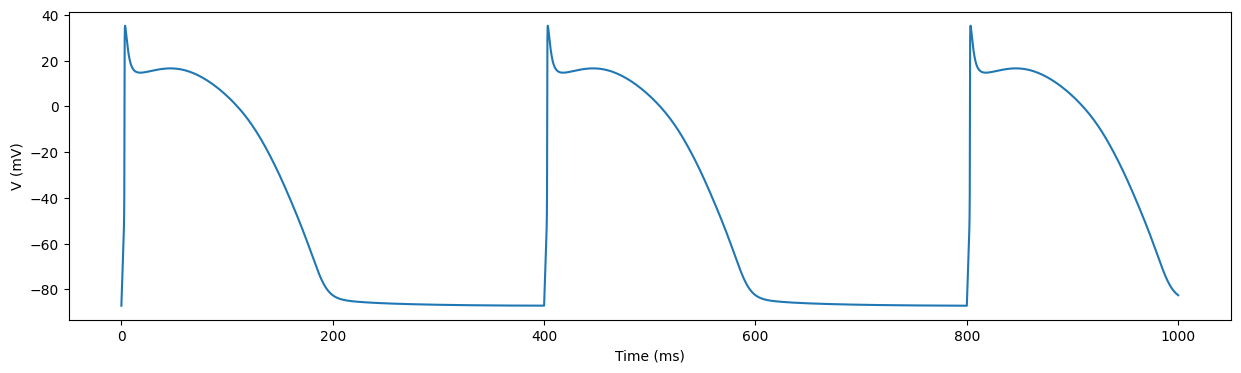

In [36]:
sim = myokit.Simulation(model, protocol)
log = sim.run(1000)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
plt.show()

No we have our model, and our ready to experiment!

### Further reading: Other model sources

Not all models make it into PMR.
By one estimate (based on the list below), around 40% of cardiac AP models are listed, with older models more likely to be included.

Increasingly, authors do provide their original code, either as a supplement to a paper or in a GitHub repository.
A long list of AP models with links to known implementations is maintained at https://github.com/myokit/model-list.
To use these models in Myokit, it is necessary to manually adapt the code.

## Changing the pacing rate

Now that we've separated the model from the pacing protocol, we can also easily change the pacing rate.

To do this, we can manually specify a new protocol:

In [48]:
protocol = myokit.parse_protocol('''
  [[protocol]]
  # Level  Start    Length   Period   Multiplier
  1.0      0.0      3.0      600.0    0
  ''')

But it's easier to use the [blocktrain](https://myokit.readthedocs.io/en/stable/api_simulations/Protocol.html#myokit.pacing.blocktrain) method:

In [ ]:
period = 600
protocol = myokit.pacing.blocktrain(period=period, duration=3)

✏️ Below, create a simulation using a new protocol with a period of 300ms, and simulate at least 5 APs.

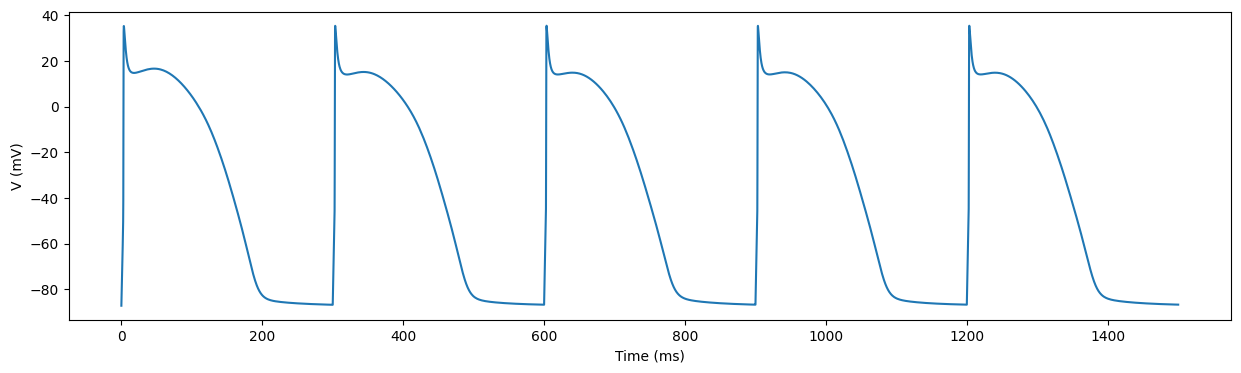

In [49]:
period = 300
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(5 * period)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
plt.show()

Looking at the shape of the APs, you should notice

1. A change in the shape from the 1st to the 5th AP, particularly in the plateau phase
2. A gradual reduction in the action potential duration (APD).

Biologically, this is highly desirable behaviour: the cell is adapting to the new pacing rate!

✏️ Create a new simulation with a pacing period of 190ms and simulate 10 APs. What happens in the first AP?

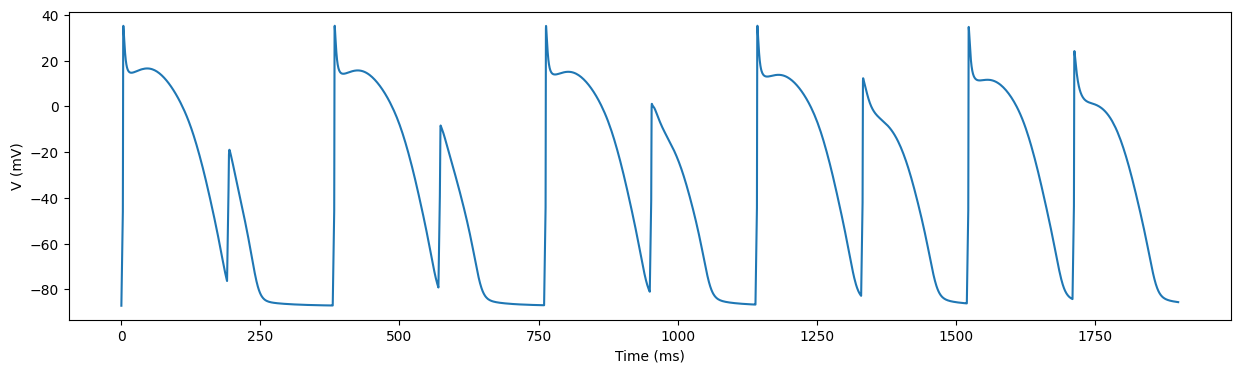

In [57]:
period = 190
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(10 * period)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
plt.show()

✏️ The speed at which the model adapts is dictated by the most slowly changing state variables. In AP models, these are usually internal ion concentrations (e.g. Na+, K+, Cl-, and most importantly Ca2+). Two important concentration variables in this model are `Na.Na_i` and `Ca.Ca_i`, representing the Na+ and Ca2+ concentrations in the cytoplasm. Using the `log` from the simulation above, plot their evolution over time:

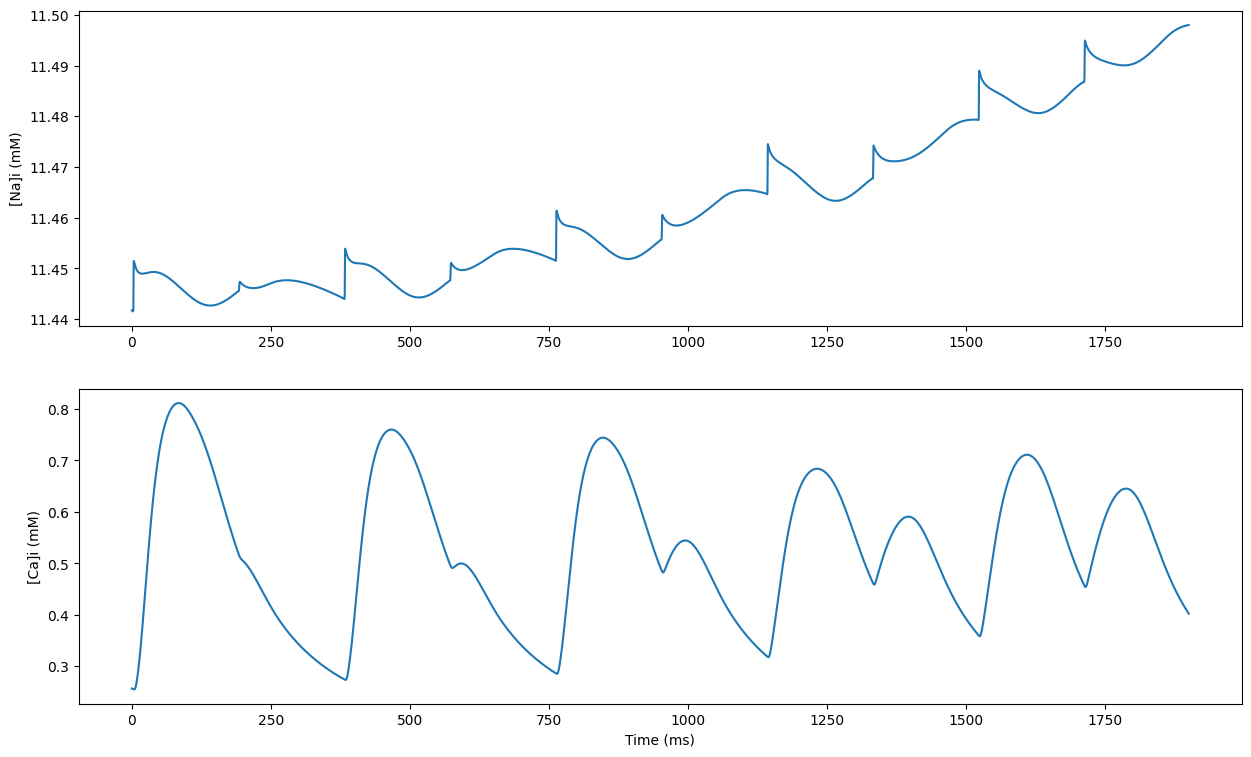

In [65]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(log.time(), log['Na.Na_i'])
ax.set_ylabel('[Na]i (mM)')
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (mM)')
ax.plot(log.time(), log['Ca.Ca_i'])
plt.show()

## Pacing to "steady state"

Simulation experiments often start by ensuring the cell has settled into a stable rhythm, and is not adapting to any changes we made (or badly chosen initial conditions).

In mathematical terms, we need to wait for the system to reach a _periodic orbit_.

But in AP modeller's jargon this is (incorrectly) called _reaching a steady state_.

To test if we're in a steady state, we're going to plot the cytosolic sodium and calcium concentrations again.
But we'll make some changes to how we run the simulation:

1. To improve performance (and allow a long simulation), we'll only log the variables we need. This can be done by passing a list to the `run` method using its `log` argument
2. To further speed things up, we'll only log _one point per period_, by setting a `log_interval`:


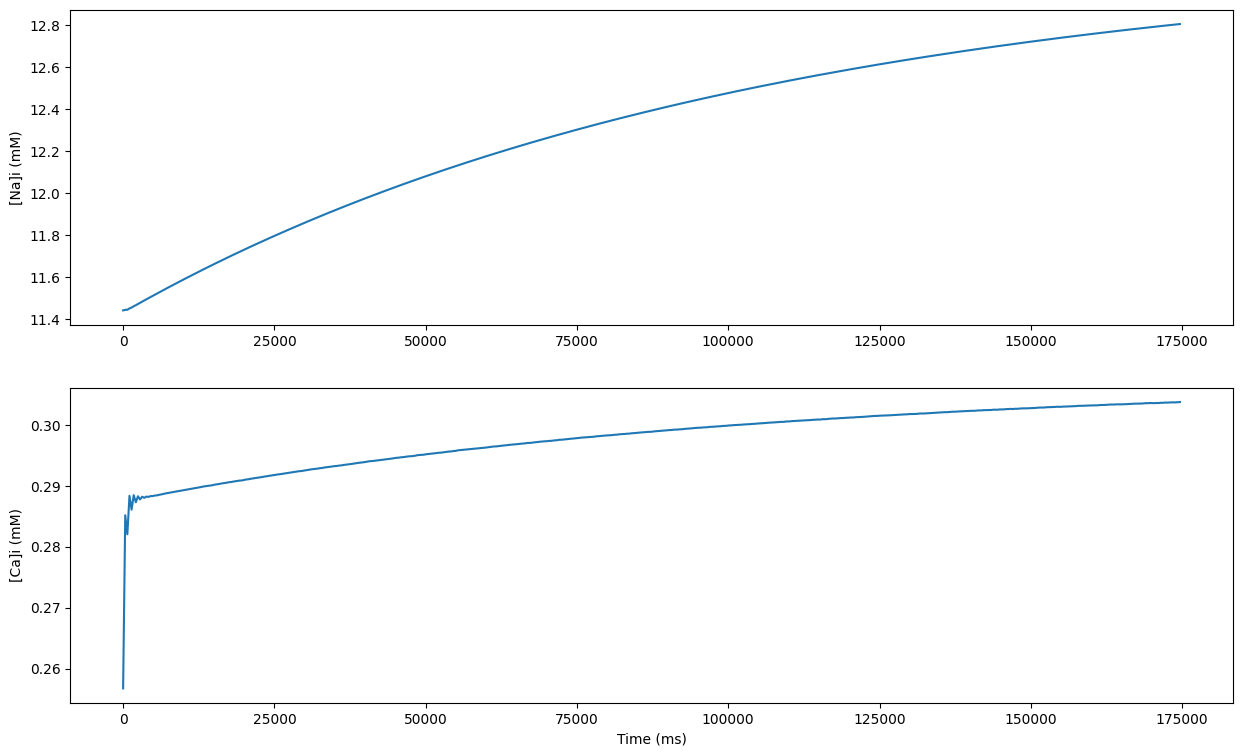

In [80]:
period = 350
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(500 * period, log=['Environment.time', 'Ca.Ca_i', 'Na.Na_i'], log_interval=period)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(log.time(), log['Na.Na_i'])
ax.set_ylabel('[Na]i (mM)')
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (mM)')
ax.plot(log.time(), log['Ca.Ca_i'])
plt.show()


This shows that, even for a modest change in pacing rate, adaptation (in this model) takes hundreds of beats.

✏️ So far, we have assumed that the model was in a "steady state" when we first loaded it. This is a dangerous assumption! Repeat the above experiment to check.

💡 Hint 1: After running once, repeat with higher precision by calling `sim.set_tolerance(1e-8, 1e-8)`.

💡 Hint 2: When reading the final values on the plots, make sure to check the top-left part of the plot, where matplotlib sometimes places an "offset". The values on the y-axis should all be read as "listed value" + "offset".

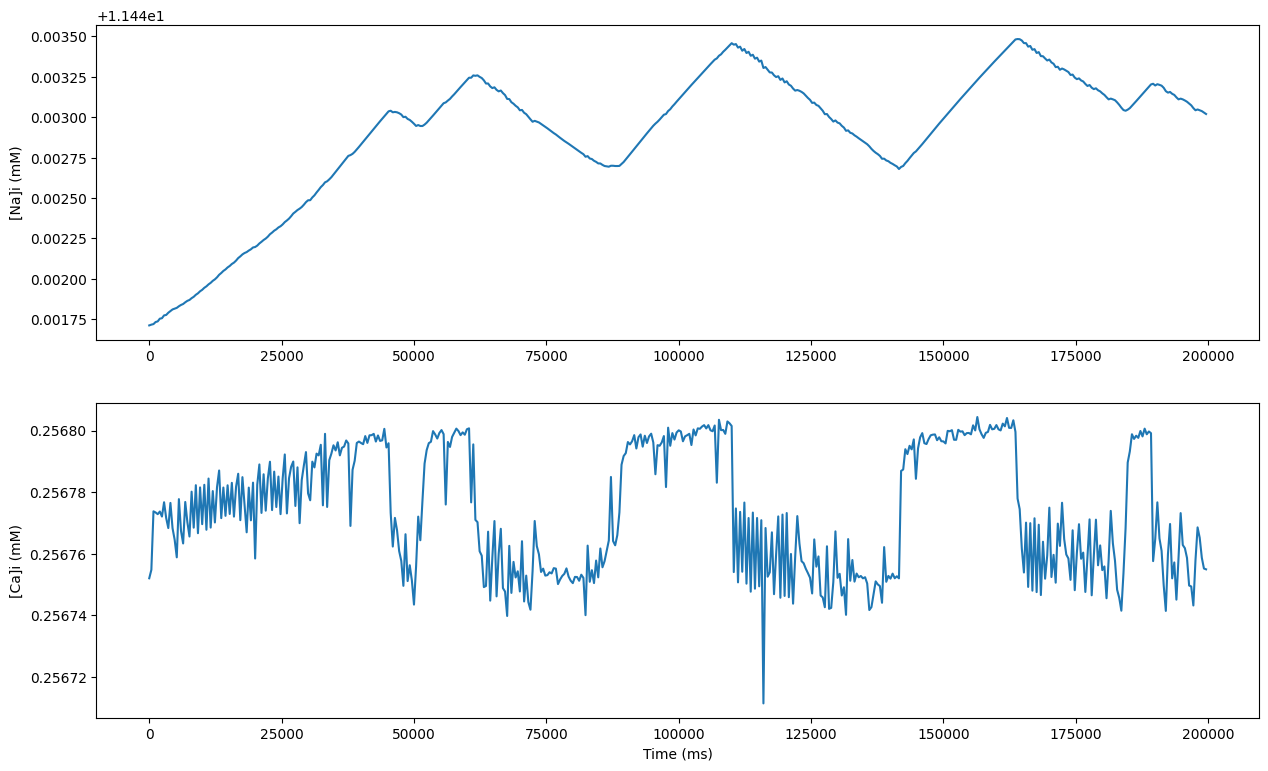

In [84]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(500 * period, log=['Environment.time', 'Ca.Ca_i', 'Na.Na_i'], log_interval=period)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(log.time(), log['Na.Na_i'])
ax.set_ylabel('[Na]i (mM)')
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (mM)')
ax.plot(log.time(), log['Ca.Ca_i'])
plt.show()


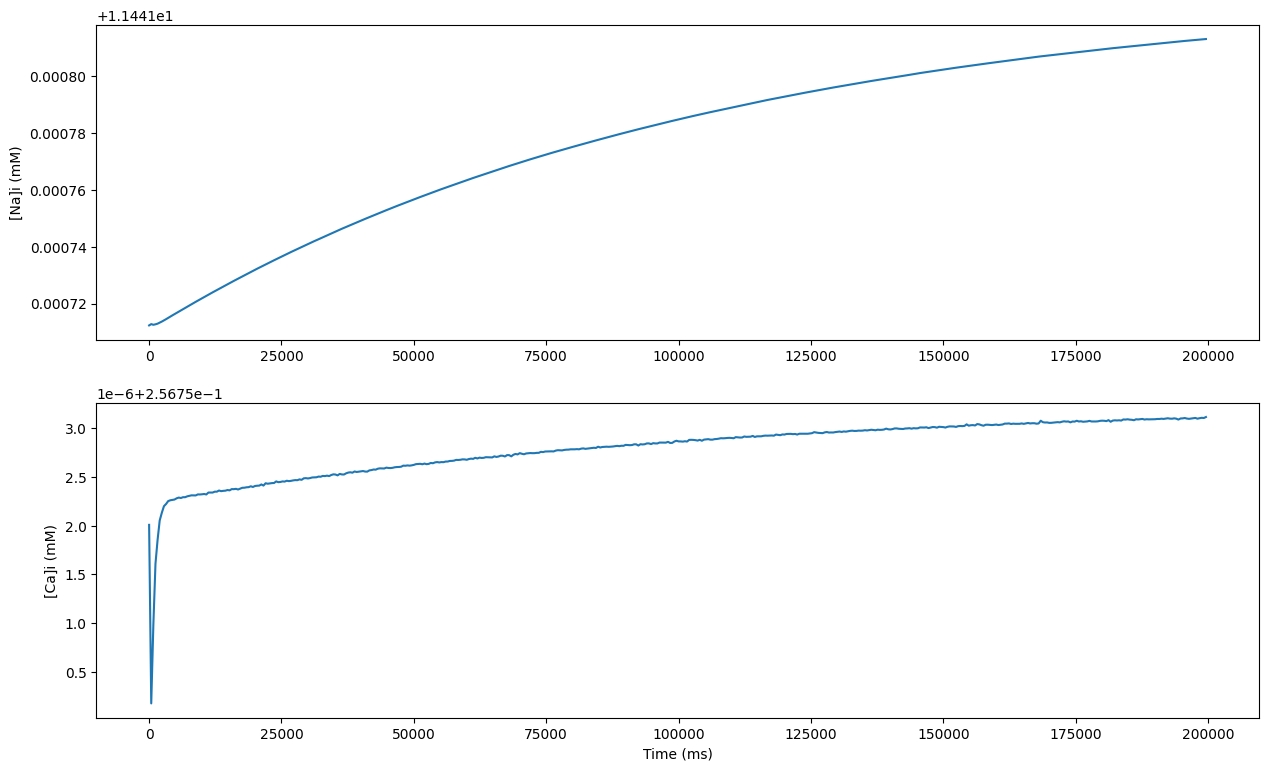

In [85]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
sim.set_tolerance(1e-8, 1e-8)
log = sim.run(500 * period, log=['Environment.time', 'Ca.Ca_i', 'Na.Na_i'], log_interval=period)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(log.time(), log['Na.Na_i'])
ax.set_ylabel('[Na]i (mM)')
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (mM)')
ax.plot(log.time(), log['Ca.Ca_i'])
plt.show()


**Note**: The long simulation times needed to bring a cell model into "steady state" is one of the reasons that whole-heart simulations typically avoid models that include internal concentration changes, using simpler models without adaptation instead.

## Calculating action potential durations

Now, let's quantify the changes to the AP we saw, by measuring the action potential duration (APD).

To do this, we'll first need to define what an "AP" is.
This can get quite complicated, but for now, we'll stick with the common definition of "any depolarisation above 10% of the voltage range", i.e. the APD90.

We'll start by running a quick simulation to find the lower and upper bounds of the voltage range.

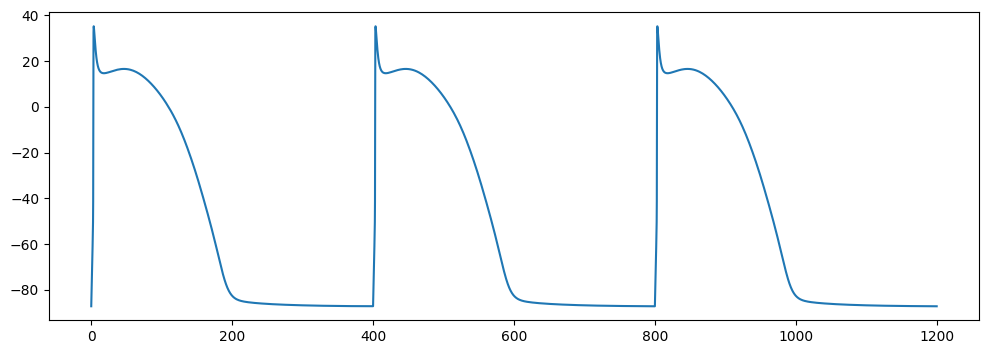

In [99]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log = sim.run(3 * period)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()
ax.plot(log.time(), log['cell.V'])
plt.show()

Now we can get the minimum and maximum voltages using `min` and `max`:

In [100]:
Vmin = min(log['cell.V'])
Vmax = max(log['cell.V'])
print(Vmin, Vmax)

-87.17457091130206 35.26923655616175


In [101]:
V90 = Vmin + 0.1 * (Vmax - Vmin)
print('Threshold:', V90)

Threshold: -74.93019016455567


Using this threshold, we run another simulation, but this time with APD measurement enabled.
We can do this by passing in a `apd_variable` and `apd_threshold` to the `run` method:

In [102]:
period = 400
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log, apds = sim.run(3 * period, apd_variable='cell.V', apd_threshold=V90)

print(apds)

DataLog({'start': [0.8668406700535571, 400.86715901223533, 800.8671443626583], 'duration': [187.70695482523573, 187.74186429275676, 187.73357737657068]})


Note how this changes the return type of the [run](https://myokit.readthedocs.io/en/stable/api_simulations/Simulation.html#myokit.Simulation.run) method: It now returns _two_ DataLogs, where the second has the entries `start` and `duration` containing the start times and durations of all detected APs.

✏️ Change the pacing frequency to 350ms, and plot APD during the first 1000 beats.

💡 You can speed up the simulation significantly by disabling logging. To do this, add `log=myokit.LOG_NONE` to the run method's arguments.

💡 For the plot's x-axis, you can use `range(len(apds['duration']))` to create a list of the numbers [0, 1, 2, ...] up to the number of APs.

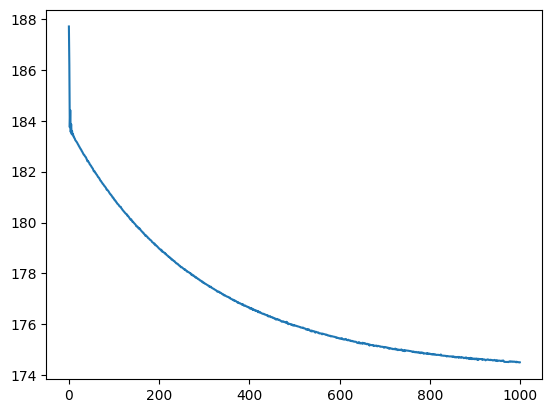

In [117]:
period = 350
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log, apds = sim.run(1000 * period, log=myokit.LOG_NONE, apd_variable='cell.V', apd_threshold=V90)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(apds['duration'])), apds['duration'])
plt.show()

✏️ Repeat this exercise with a period of 200ms. What do you observe?

💡 If the plot looks strange, try zooming in on the final 10 APs with `ax.set_xlim(990, 1000)`.

In [123]:
period = 200
protocol = myokit.pacing.blocktrain(period=period, duration=3)
sim = myokit.Simulation(model, protocol)
log, apds = sim.run(1000 * period, log=myokit.LOG_NONE, apd_variable='cell.V', apd_threshold=V90)

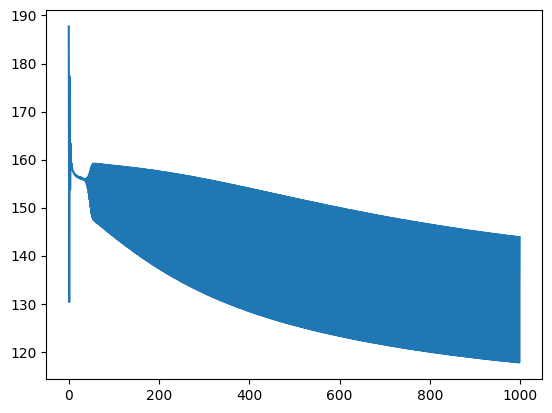

In [122]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(apds['duration'])), apds['duration'])
plt.show()

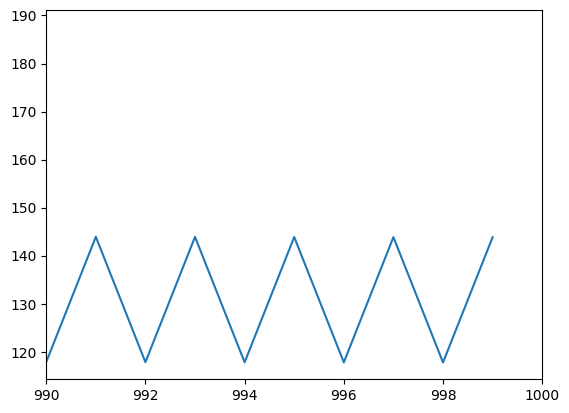

In [121]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(apds['duration'])), apds['duration'])
ax.set_xlim(990, 1000)
plt.show()

At this rate, the system doesn't settle into a periodic orbit of 200ms.
Instead, the APD alternates between two stable values: it might still be periodic, but the period has doubled to 400ms!

In cell electrophysiology, this is known as _alternans_ and is of particular interest because some types of alternans are associated with reentrant arrhythmia.

## Restitution

The XXXXXXXXXXXXXXXXXXXXXXX _restitution_.

...............


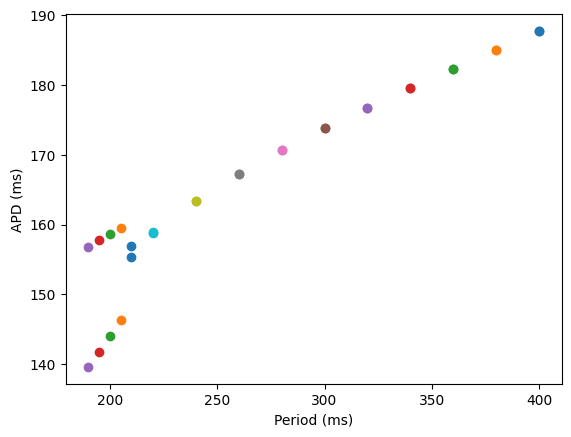

In [129]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Period (ms)')
ax.set_ylabel('APD (ms)')

sim = myokit.Simulation(model, protocol)
for period in [400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 210, 205, 200, 195, 190]:
  sim.reset()
  sim.set_protocol(myokit.pacing.blocktrain(period=period, duration=3))
  sim.run(100 * period, log=myokit.LOG_NONE)
  log, apds = sim.run(2 * period, apd_variable='cell.V', apd_threshold=V90)
  ax.plot([period, period], apds['duration'], 'o')
  print('.', end='')
print()
plt.show()


## Apply simulated drug block or mutation by scaling a conductance and seeing how things change.


## Nice to show EAD or something happening, to link to arrhythmic whole-cell ideas (but let others do that).